In [1]:
from easydict import EasyDict as edict
import json, os
import torch

import pandas as pd
import numpy as np

from scipy.special import expit

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/home/users/jschott/Chexpert/')
from model.classifier import Classifier
from data.dataset import ImageDataset  

## Laden der Testdaten

### CheXpert Datensatz hat einen besonderen Testdatensatz den wir hier laden (orignal)

In [3]:
datapath = '/work/projects/covid19_dv/raw_data/heavy_datasets/chexpert_stanford'

# place of the original validation data
original_validation_csv = pd.read_csv(os.path.join(datapath, 'CheXpert-v1.0/valid.csv'))

# Hier passen wir den Dateipfad an
original_validation_csv.Path = original_validation_csv.Path.apply(lambda x: os.path.join(datapath, x))

Write original test data file to disk

In [4]:
filename_original_testdata = '/home/users/jschott/chexpert_eval/test_orginal.csv'

dirname = os.path.dirname(filename_original_testdata)
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
original_validation_csv.to_csv(filename_original_testdata, index=False)

### Wir haben einen **eigenen** Test- (Validierungs)datensatz gebaut, den wir hier laden

In [5]:
custom_validation_csv = pd.read_csv('/work/projects/covid19_dv/jessica_ba/config/valid_exp1.csv')

Write our test data file to disk

In [6]:
filename_custom_testdata = '/home/users/jschott/chexpert_eval/test_custom.csv'

dirname = os.path.dirname(filename_custom_testdata)
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
custom_validation_csv.to_csv(filename_custom_testdata, index=False)

#### Load model

In [7]:
#which_model = 'pretrained'
#which_model = 'exp1small'
#which_model = 'exp_selection_female'
#which_model = 'exp_70k'
#which_model = 'exp_female_70k'
#which_model = 'exp_1_male_70k' !!!!!
#which_model = 'exp_2_male_70k'
#which_model = 'exp_3_male_70k' !!!!
which_model = 'exp_4_male_70k'
#evaluate_on = filename_original_testdata
evaluate_on = filename_custom_testdata

In [8]:
if which_model == 'pretrained':
    args = {
        'config': '/home/users/jschott/Chexpert/config/example.json',
        'model_weight': '/home/users/jschott/Chexpert/config/pre_train.pth',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }

elif which_model == 'exp1small':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
elif which_model == 'exp_selection_female':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_female/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_female/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
elif which_model == 'exp_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
elif which_model == 'exp_female_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_female_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_fmale_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
   
elif which_model == 'exp_male_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_male_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_male_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
elif which_model == 'exp_1_male_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_male_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_male_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }
elif which_model == 'exp_2_male_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_male_2_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_male_2_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    } 
elif which_model == 'exp_3_male_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_3_male_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_3_male_70k/best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }  
elif which_model == 'exp_4_male_70k':
    args = {
        'config': '/work/projects/covid19_dv/jessica_ba/results_1_male_70k/cfg.json',
        'model_weight': '/work/projects/covid19_dv/jessica_ba/results_1_male_70k//best1.ckpt',       # "Path to the trained models"
        'in_csv_path': evaluate_on,   # "Path to the input image path in csv"
        'num_workers': 8,             # "workers for each data loader"
    }  

else:
    assert(False, 'No model was found')
    
    
args

{'config': '/work/projects/covid19_dv/jessica_ba/results_1_male_70k/cfg.json',
 'model_weight': '/work/projects/covid19_dv/jessica_ba/results_1_male_70k//best1.ckpt',
 'in_csv_path': '/home/users/jschott/chexpert_eval/test_custom.csv',
 'num_workers': 8}

In [9]:
device = 'cuda:0'

In [10]:
# open config
with open(args['config']) as f:
    cfg = edict(json.load(f))

# create model
model = Classifier(cfg)
_ = model.to(device)

# load pretrained weights/parameter
# selbsttrainiertes Model
ckpt = torch.load(args['model_weight'], map_location='cpu')

if 'exp' in which_model:
    model.load_state_dict(ckpt['state_dict'])
else:
    model.load_state_dict(ckpt)

### Create Dataloader
(zum laden des Datensatzes)

In [11]:
dataset = ImageDataset(args['in_csv_path'], cfg, mode='test')
dataloader_test = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.dev_batch_size, 
    num_workers=args['num_workers'],
    drop_last=False, 
    shuffle=False
)

In [12]:
prediction_pathology = [
    'Cardiomegaly',
    'Edema',
    'Consolidation',
    'Atelectasis',
    'Pleural Effusion'
]

## Vorhersagen durchfueheren

In [13]:
model.eval()

predictions = []
for image_batch, path in dataloader_test:
    with torch.no_grad():
        batch_prediction, _ = model(image_batch.to(device))
    batch_prediction = np.hstack([p.cpu().numpy() for p in batch_prediction])
    predictions.append(batch_prediction)
predictions = np.vstack(predictions)

In [14]:
# konvertieren der Modellausgabe zu Wahrscheinlichkeiten (sigmoid funktion) 
probabilities = expit(predictions)

# umwandeln in pandas dataframe
probabilities = pd.DataFrame(probabilities, columns=prediction_pathology)

#### Abspeichern der Predictions

In [15]:
if 'test_custom' in evaluate_on:
    probabilities.to_csv(os.path.dirname(args['model_weight'])+ '/test_custom_predictions.csv')
elif 'test_orginal' in evaluate_on:
    probabilities.to_csv(os.path.dirname(args['model_weight'])+ '/test_original_predictions.csv')

<AxesSubplot:>

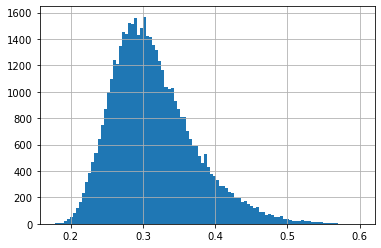

In [16]:
probabilities['Cardiomegaly'].hist(bins= 100)

### Evaluation des Modells

d.h. vergleich mit den "echten" Targets

In [17]:
import sklearn.metrics as skm

In [18]:
#evaluate_on = original_validation_csv.copy()
evaluate_on = custom_validation_csv.copy()

In [19]:
evaluate_on

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,PatientId
0,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,patient00005
1,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,33,Lateral,NaN,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,patient00005
2,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,patient00005
3,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,33,Frontal,AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,patient00005
4,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,76,Frontal,PA,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,patient00009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45897,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,77,Frontal,AP,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,patient64528
45898,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,81,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,patient64529
45899,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN,patient64537
45900,/work/projects/covid19_dv/raw_data/heavy_datas...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN,patient64537


#### Performance fuer eine Krankeit

In [20]:
col = 'Edema'

targets = evaluate_on[col].fillna(0)    # Spalte Atelektasis mit 0en Auffüllen
not_ignore = targets >= 0               # ignoriere alle Werte kleiner 0
print(f'{(~not_ignore).sum()} images neglected due to -1') # formatiert den String (die Variable in den geschweiften Klammern)

skm.roc_auc_score(targets[not_ignore], probabilities[col][not_ignore]) # berechne, wie gut das Modell vorhersagt für die jeweilige Krankheit mit den Werten >= 0
skm.log_loss(targets[not_ignore], probabilities[col][not_ignore]) # berechne, wie gut das Modell vorhersagt für die jeweilige Krankheit mit den Werten >= 0

2656 images neglected due to -1


0.5589014666507904

Text(0, 0.5, '# cases')

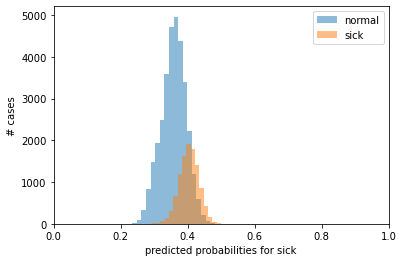

In [21]:
plt.hist(probabilities[col][not_ignore][targets[not_ignore] == 0], alpha=0.5, bins=20, label='normal')
plt.hist(probabilities[col][not_ignore][targets[not_ignore] == 1], alpha=0.5, bins=20, label='sick')
plt.legend()
plt.xlabel('predicted probabilities for sick')
plt.xlim([0, 1])
plt.ylabel('# cases')

In [22]:
prediction_pathology

['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']

In [23]:
probabilities[col][not_ignore].shape

(43246,)

#### Performance fuer alle 5 Krankheiten

In [24]:
diseases = []
diseases_log_loss= []

for i, col in enumerate(prediction_pathology):
    targets = evaluate_on[col].fillna(0)
    not_ignore = targets >= 0
    diseases.append(skm.roc_auc_score(targets[not_ignore], probabilities[col][not_ignore]))
    diseases_log_loss.append(skm.log_loss(targets[not_ignore], probabilities[col][not_ignore]))
    
print(diseases)
print(diseases_log_loss)

[0.8358175387881228, 0.8407258256867256, 0.7003148236834489, 0.6729711926788324, 0.866770358827352]
[0.44154783325037666, 0.5589014666507904, 0.6042902014464758, 0.7397527940388694, 0.6492038613214661]


#### Performance getrennt nach Geschlecht

In [25]:
selection_male = evaluate_on.Sex == 'Male'
selection_female = evaluate_on.Sex == 'Female'

In [26]:
diseases_m = []
diseases_f = []

for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_male ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_m.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_male, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_female ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_f.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_female, col][not_ignore]))
        
print(diseases_m)
print(diseases_f)

[0.844459410845386, 0.8452038557456399, 0.6871968374025641, 0.6711075362486657, 0.8581130152783837]
[0.8229444752427129, 0.8353719187522073, 0.7211396866127975, 0.6761914473301638, 0.8798895504126598]


In [27]:
diseases_m_log_loss = []
diseases_f_log_loss = []

for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_male ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_m_log_loss.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_male, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_female ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_f_log_loss.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_female, col][not_ignore]))
    
print(diseases_m_log_loss)
print(diseases_f_log_loss)

[0.436444017509453, 0.5496365039559196, 0.6040994134201496, 0.7387681377652638, 0.6488080225551186]
[0.44898541241019607, 0.5724564479530937, 0.6045693299694782, 0.7411895719611962, 0.649779237659506]


In [28]:
scores = pd.DataFrame([diseases, diseases_m, diseases_f], columns= prediction_pathology, index= ['all', 'male', 'female'])
scores_log_less = pd.DataFrame([diseases_log_loss, diseases_m_log_loss, diseases_f_log_loss], columns= prediction_pathology, index= ['all', 'male', 'female'])

In [29]:
import seaborn as sns

In [30]:
data = scores.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'AUC'})
data_log_loss = scores_log_less.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'LOG LOSS'})

<AxesSubplot:xlabel='diseases', ylabel='AUC'>

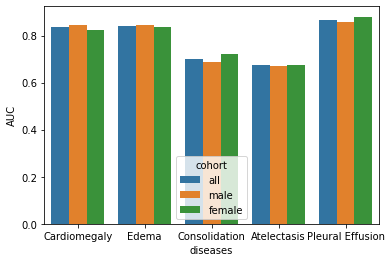

In [31]:
sns.barplot(data = data, x = 'diseases', hue='cohort', y='AUC')

<AxesSubplot:xlabel='diseases', ylabel='LOG LOSS'>

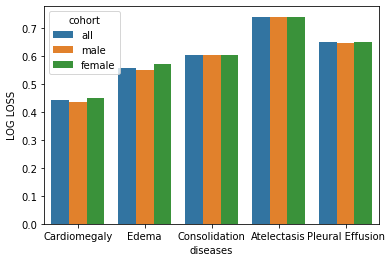

In [32]:
sns.barplot(data = data_log_loss, x = 'diseases', hue='cohort', y='LOG LOSS')

## Performance getrennt nach Altersgruppe

In [33]:
### trennen nach altersgruppe (schwierigkeit stufe 1)

In [34]:
selection_teens = (evaluate_on.Age >= 10) & (evaluate_on.Age < 20)
selection_twenties = (evaluate_on.Age >= 20) & (evaluate_on.Age < 30)
selection_thirties = (evaluate_on.Age >= 30) & (evaluate_on.Age < 40)
selection_fourties = (evaluate_on.Age >= 40) & (evaluate_on.Age < 50)
selection_fifties = (evaluate_on.Age >= 50) & (evaluate_on.Age < 60)
selection_sixties = (evaluate_on.Age >= 60) & (evaluate_on.Age < 70)
selection_seventies = (evaluate_on.Age >= 70) & (evaluate_on.Age < 80)
selection_eighties = (evaluate_on.Age >= 80) & (evaluate_on.Age < 90)
selection_nineties = (evaluate_on.Age >= 90)

In [35]:
evaluate_on.Age

0        33
1        33
2        33
3        33
4        76
         ..
45897    77
45898    81
45899    59
45900    59
45901     0
Name: Age, Length: 45902, dtype: int64

In [36]:
diseases_teens= []
diseases_twenties= []
diseases_thirties = []
diseases_fourties = []
diseases_fifties = []
diseases_sixties = []
diseases_seventies = []
diseases_eighties = []
diseases_nineties = []


for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[selection_teens ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_teens.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_teens, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_twenties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_twenties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_twenties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_thirties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_thirties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_thirties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fourties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fourties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_fourties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fifties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fifties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_fifties, col][not_ignore]))
        
    targets = evaluate_on.loc[selection_sixties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_sixties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_sixties, col][not_ignore]))
            
    targets = evaluate_on.loc[selection_seventies ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_seventies.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_seventies, col][not_ignore]))        
    
    targets = evaluate_on.loc[selection_eighties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_eighties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_eighties, col][not_ignore]))        
   
    targets = evaluate_on.loc[selection_nineties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_nineties.append(skm.roc_auc_score(targets[not_ignore], probabilities.loc[selection_nineties, col][not_ignore]))
    
print(diseases_teens)
print(diseases_twenties)
print(diseases_thirties)
print(diseases_fourties)
print(diseases_fifties)
print(diseases_sixties)
print(diseases_seventies)
print(diseases_eighties)
print(diseases_nineties)

[0.8359402772840384, 0.8552271483305967, 0.7132675438596491, 0.7327843418068982, 0.9051713395638629]
[0.8695151206059576, 0.8648031446933301, 0.7273396763962803, 0.746065933937257, 0.8803704403572129]
[0.8682378913037916, 0.8564699586128157, 0.7281211017983825, 0.7113243353062589, 0.8793970556520359]
[0.833934377695767, 0.8480193638865765, 0.6951294964028776, 0.7037236711519559, 0.8865717905062264]
[0.849742964785215, 0.8468940841943161, 0.715317290322716, 0.6815893448314666, 0.8715982861919326]
[0.8162283870333277, 0.8348263072370931, 0.6922821125929406, 0.6497199153995981, 0.8560826370413919]
[0.8271189435045764, 0.8239259327133396, 0.6907664010745794, 0.646883580450302, 0.8488427614159405]
[0.7968269843940518, 0.8204644275954678, 0.6872873337498885, 0.6319152090652682, 0.8442092009112441]
[0.7581237383697996, 0.7844895102156696, 0.634944338854195, 0.6068534792461173, 0.8604473088778021]


In [37]:
scores_age = pd.DataFrame([diseases, diseases_teens, diseases_twenties, diseases_thirties, diseases_fourties, diseases_fifties, diseases_sixties, diseases_seventies, diseases_eighties, diseases_nineties], 
                          columns= prediction_pathology, 
                          index= ['all', 'teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties'])

In [38]:
data_age = scores_age.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'AUC'})

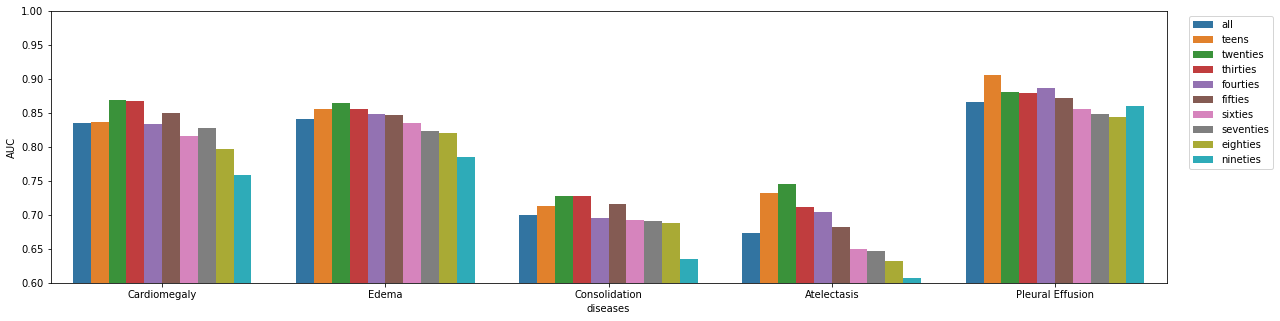

In [39]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(data = data_age, x = 'diseases', hue='cohort', y='AUC', ax=ax)
plt.ylim([0.6, 1])
plt.legend(loc= 'upper right', bbox_to_anchor=(1.1,1))

In [40]:
diseases_teens= []
diseases_twenties= []
diseases_thirties = []
diseases_fourties = []
diseases_fifties = []
diseases_sixties = []
diseases_seventies = []
diseases_eighties = []
diseases_nineties = []
diseases_all = []


for i, col in enumerate(prediction_pathology):
    
    targets = evaluate_on.loc[:,col].fillna(0)
    not_ignore = targets >= 0
    diseases_all.append(skm.log_loss(targets[not_ignore], probabilities.loc[:, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_teens ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_teens.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_teens, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_twenties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_twenties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_twenties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_thirties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_thirties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_thirties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fourties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fourties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_fourties, col][not_ignore]))
    
    targets = evaluate_on.loc[selection_fifties,col].fillna(0)
    not_ignore = targets >= 0
    diseases_fifties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_fifties, col][not_ignore]))
        
    targets = evaluate_on.loc[selection_sixties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_sixties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_sixties, col][not_ignore]))
            
    targets = evaluate_on.loc[selection_seventies ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_seventies.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_seventies, col][not_ignore]))        
    
    targets = evaluate_on.loc[selection_eighties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_eighties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_eighties, col][not_ignore]))        
   
    targets = evaluate_on.loc[selection_nineties ,col].fillna(0)
    not_ignore = targets >= 0
    diseases_nineties.append(skm.log_loss(targets[not_ignore], probabilities.loc[selection_nineties, col][not_ignore]))
    
print(diseases_teens)
print(diseases_twenties)
print(diseases_thirties)
print(diseases_fourties)
print(diseases_fifties)
print(diseases_sixties)
print(diseases_seventies)
print(diseases_eighties)
print(diseases_nineties)

[0.38578034955248847, 0.5037848251869499, 0.5763700194288008, 0.7237979909190742, 0.6078967082998383]
[0.38848696087573675, 0.48713568168606114, 0.5713245871908221, 0.7187889743655447, 0.609666175681426]
[0.39491116927891246, 0.5072691307282929, 0.5858455785005897, 0.7281873453630194, 0.6197439360909796]
[0.41319016422381294, 0.5345687138306133, 0.5951209082448727, 0.7319124111635756, 0.636453750965448]
[0.42477306627684797, 0.5488478068971514, 0.5981509589389071, 0.7365485450797007, 0.645514080805189]
[0.43382920413281856, 0.5575594148853743, 0.6093715984091856, 0.7428247093798029, 0.6564279107021082]
[0.4690985870491855, 0.5943244036641488, 0.6175327689304254, 0.7481757296439528, 0.6644636708383929]
[0.5046981789113939, 0.6068339867794768, 0.6203416917841318, 0.7507884741741909, 0.6686744606523163]
[0.5418635421610433, 0.625872684631519, 0.6294027579079071, 0.7592060969292042, 0.6697050766053879]


In [41]:
log_loss_scores_age = pd.DataFrame([diseases_all, diseases_teens, diseases_twenties, diseases_thirties, diseases_fourties, diseases_fifties, diseases_sixties, diseases_seventies, diseases_eighties, diseases_nineties], 
                          columns= prediction_pathology, 
                          index= ['all', 'teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties', 'nineties'])

In [42]:
data_age_loss = log_loss_scores_age.stack().reset_index().rename(columns = {'level_0' : 'cohort', 'level_1' : 'diseases', 0 : 'Log Loss'})

(0.2, 1.1)

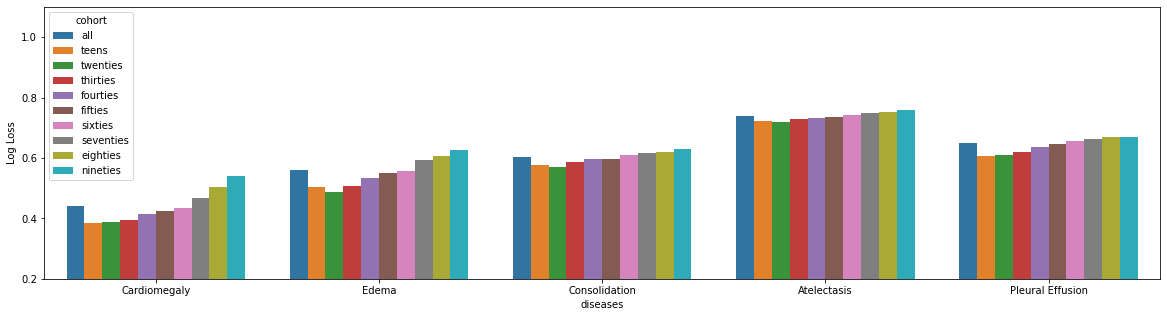

In [43]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
sns.barplot(data = data_age_loss, x = 'diseases', hue='cohort', y='Log Loss', ax=ax)
plt.ylim([0.2, 1.1])

## Performance getrennt nach Geschlecht auf 100 zufaelligen sub-samples

In [44]:
### umbauen auf die neuen variablen (Varianz (100 Messungen))

In [45]:
rand_list_m = []
rand_list_f = []
rand_list_m_log_loss = []
rand_list_f_log_loss = []


for i in range(100):
    random_selection = np.random.rand(len(evaluate_on)) >= 0.2
    
    diseases_m = []
    diseases_f = []
    diseases_m_log_loss = []
    diseases_f_log_loss = []
    
    for i, col in enumerate(prediction_pathology):
        diseases_m.append(skm.roc_auc_score(evaluate_on.fillna(0).loc[selection_male&random_selection,col], probabilities.loc[selection_male&random_selection,col]))
        diseases_f.append(skm.roc_auc_score(evaluate_on.fillna(0).loc[selection_female&random_selection,col], probabilities.loc[selection_female&random_selection,col]))
        diseases_m_log_loss.append(skm.log_loss(evaluate_on.fillna(0).loc[selection_male&random_selection,col], probabilities.loc[selection_male&random_selection,col]))
        diseases_f_log_loss.append(skm.log_loss(evaluate_on.fillna(0).loc[selection_female&random_selection,col], probabilities.loc[selection_female&random_selection,col]))


    rand_list_m.append(diseases_m)
    rand_list_f.append(diseases_f)
    rand_list_m_log_loss.append(diseases_m_log_loss)
    rand_list_f_log_loss.append(diseases_f_log_loss)


ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
matrix_m = np.array(rand_list_m)
matrix_m_log_loss = np.array(rand_list_m_log_loss)
print(matrix_m.mean(axis=0))
print(matrix_m.std(axis=0))

In [ ]:
matrix_f = np.array(rand_list_f)
matrix_f_log_loss = np.array(rand_list_f_log_loss)
print(matrix_f.mean(axis=0))
print(matrix_f.std(axis=0))

In [ ]:
df_m_auc = pd.DataFrame(matrix_m_log_loss, columns = prediction_pathology).stack()

In [ ]:
df_m_log_loss = pd.DataFrame(matrix_m, columns = prediction_pathology).stack()

In [ ]:
df_m_c = pd.concat([df_m_log_loss, df_m_auc], axis=1)       # axis = 1 bedeutet nebeneinander als Spalten (statt untereinander)

In [ ]:
df_m = df_m_c.reset_index()
df_m = df_m.rename(columns= {'level_0': 'round', 'level_1': 'pathology', 0: 'auc', 1: 'log loss'})

df_m['Sex'] = 'male'

In [ ]:
df_m.head()

In [ ]:
df_f_auc = pd.DataFrame(matrix_f_log_loss, columns = prediction_pathology).stack()
df_f_log_loss = pd.DataFrame(matrix_f, columns = prediction_pathology).stack()
df_f_c = pd.concat([df_f_log_loss, df_f_auc], axis=1)       # axis = 1 bedeutet nebeneinander als Spalten (statt untereinander)
df_f = df_f_c.reset_index()
df_f = df_f.rename(columns= {'level_0': 'round', 'level_1': 'pathology', 0: 'auc', 1: 'log loss'})
df_f['Sex'] = 'female'
df_f.head()

In [ ]:
df = pd.concat([df_m, df_f])

In [ ]:
sex=['female','male']

ax = sns.boxplot(data=df, x = 'pathology', y = 'auc',hue='Sex')
plt.ylim(0.5,1)

In [ ]:
sex=['female','male']

ax = sns.boxplot(data=df, x = 'pathology', y = 'log loss',hue='Sex')
#plt.ylim(0.5,1)